# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [69]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

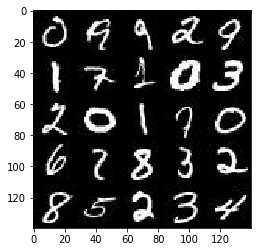

In [70]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

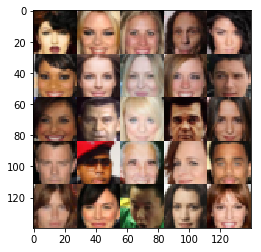

In [71]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [72]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [73]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_images = tf.placeholder(dtype = tf.float32, shape = [None, image_width, image_height, image_channels])
    z_data = tf.placeholder(dtype = tf.float32, shape = [None, z_dim])
    learning_rate = tf.placeholder(dtype = tf.float32, shape = [])

    return input_images, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [74]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse = reuse):
        alpha = 0.1
        
        # 28x28x3 to 14x14x64
        h1 = tf.layers.conv2d(images, 64, 5, strides = 2, padding = 'same')
        relu1 = tf.maximum(alpha * h1, h1)
        
        # 14x14x64 to 7x7x128
        h2 = tf.layers.conv2d(relu1, 128, 5, strides = 2, padding = 'same')
        bn2 = tf.layers.batch_normalization(h2, training = True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        # 7x7x128 to 4x4x256
        h3 = tf.layers.conv2d(relu2, 256, 5, strides = 2, padding = 'same')
        bn3 = tf.layers.batch_normalization(h3, training = True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [75]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.1
    with tf.variable_scope('generator', reuse = not is_train):
        h1 = tf.layers.dense(z, 7*7*512)
        
        h1 = tf.reshape(h1, (-1, 7, 7, 512))
        h1 = tf.layers.batch_normalization(h1, training = is_train)
        h1 = tf.maximum(alpha * h1, h1)
        
        h2 = tf.layers.conv2d_transpose(h1, 256, 5, strides = 2, padding = 'same')
        h2 = tf.layers.batch_normalization(h2, training = is_train)
        h2 = tf.maximum(alpha * h2, h2)
        
        h3 = tf.layers.conv2d_transpose(h2, 128, 5, strides = 2, padding = 'same')
        h3 = tf.layers.batch_normalization(h3, training = is_train)
        h3 = tf.maximum(alpha * h3, h3)
        
        logits = tf.layers.conv2d_transpose(h3, out_channel_dim, 5, strides =1, padding = 'same')
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [76]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train = True)
    d_model_real, d_logits_real = discriminator(input_real, reuse = False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse = True)
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, labels = tf.ones_like(d_model_fake)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, labels = tf.zeros_like(d_model_fake)))
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_real, labels = tf.ones_like(d_model_real)))
    
    d_loss = d_loss_fake + d_loss_real
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [77]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    train_vars = tf.trainable_variables()
    g_vars = [var for var in train_vars if var.name.startswith('generator')]
    d_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_train_opt = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1 = beta1).minimize(d_loss, var_list = d_vars)
        d_train_opt = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1 = beta1).minimize(g_loss, var_list = g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [78]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [80]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_images, z_data, _ = model_inputs(data_shape[1], data_shape[2], data_shape[3],z_dim)
    d_loss, g_loss = model_loss(input_images, z_data, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images = batch_images * 2
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_images: batch_images, z_data: batch_z})
                _ = sess.run(g_train_opt, feed_dict={z_data: batch_z, input_images: batch_images})

                if steps == 1:
                    print('initial output:')
                    show_generator_output(sess, 16, z_data, data_shape[3], data_image_mode)
                    
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({z_data: batch_z, input_images: batch_images})
                    train_loss_g = g_loss.eval({z_data: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                if steps % 100 == 0:
                    show_generator_output(sess, 16, z_data, data_shape[3], data_image_mode)
              
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

initial output:


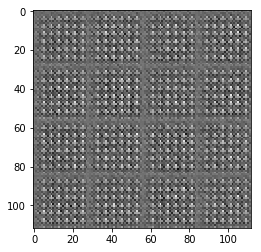

Epoch 1/2... Discriminator Loss: 0.0279... Generator Loss: 4.6980
Epoch 1/2... Discriminator Loss: 0.0242... Generator Loss: 6.0284
Epoch 1/2... Discriminator Loss: 0.0279... Generator Loss: 10.8738
Epoch 1/2... Discriminator Loss: 0.6355... Generator Loss: 10.2516
Epoch 1/2... Discriminator Loss: 1.4221... Generator Loss: 4.6197
Epoch 1/2... Discriminator Loss: 0.3764... Generator Loss: 3.3208
Epoch 1/2... Discriminator Loss: 0.5161... Generator Loss: 1.6376
Epoch 1/2... Discriminator Loss: 0.5502... Generator Loss: 1.4749
Epoch 1/2... Discriminator Loss: 0.6603... Generator Loss: 1.6336
Epoch 1/2... Discriminator Loss: 0.8356... Generator Loss: 1.3570


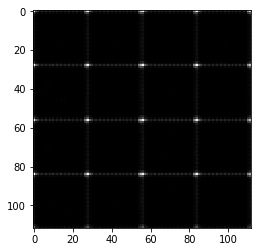

Epoch 1/2... Discriminator Loss: 0.7348... Generator Loss: 1.5816
Epoch 1/2... Discriminator Loss: 1.0724... Generator Loss: 0.6922
Epoch 1/2... Discriminator Loss: 0.9217... Generator Loss: 0.8862
Epoch 1/2... Discriminator Loss: 0.7821... Generator Loss: 1.4503
Epoch 1/2... Discriminator Loss: 0.7990... Generator Loss: 1.6557
Epoch 1/2... Discriminator Loss: 0.9040... Generator Loss: 1.6573
Epoch 1/2... Discriminator Loss: 1.0294... Generator Loss: 0.7730
Epoch 1/2... Discriminator Loss: 0.9536... Generator Loss: 0.9727
Epoch 1/2... Discriminator Loss: 0.9114... Generator Loss: 1.4414
Epoch 1/2... Discriminator Loss: 0.9048... Generator Loss: 1.8902


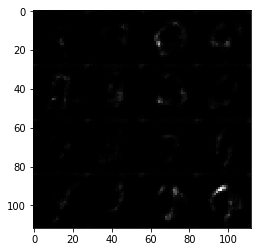

Epoch 1/2... Discriminator Loss: 1.0270... Generator Loss: 0.7061
Epoch 1/2... Discriminator Loss: 0.8987... Generator Loss: 1.4376
Epoch 1/2... Discriminator Loss: 1.2133... Generator Loss: 2.4216
Epoch 1/2... Discriminator Loss: 1.0895... Generator Loss: 2.3327
Epoch 1/2... Discriminator Loss: 1.0392... Generator Loss: 0.6809
Epoch 1/2... Discriminator Loss: 0.9619... Generator Loss: 1.8983
Epoch 1/2... Discriminator Loss: 0.9102... Generator Loss: 1.0927
Epoch 1/2... Discriminator Loss: 1.3117... Generator Loss: 0.4781
Epoch 1/2... Discriminator Loss: 0.8716... Generator Loss: 1.1645
Epoch 1/2... Discriminator Loss: 0.9434... Generator Loss: 1.3481


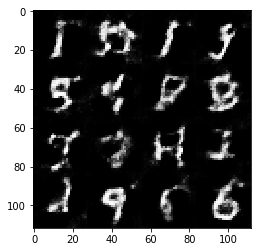

Epoch 1/2... Discriminator Loss: 0.9329... Generator Loss: 1.6772
Epoch 1/2... Discriminator Loss: 0.8782... Generator Loss: 1.1531
Epoch 1/2... Discriminator Loss: 0.9437... Generator Loss: 0.8801
Epoch 1/2... Discriminator Loss: 1.1313... Generator Loss: 0.5975
Epoch 1/2... Discriminator Loss: 0.9665... Generator Loss: 1.6802
Epoch 1/2... Discriminator Loss: 0.9464... Generator Loss: 0.9596
Epoch 1/2... Discriminator Loss: 0.9737... Generator Loss: 0.8214
Epoch 1/2... Discriminator Loss: 1.0062... Generator Loss: 0.7776
Epoch 1/2... Discriminator Loss: 0.9811... Generator Loss: 0.7986
Epoch 1/2... Discriminator Loss: 0.9306... Generator Loss: 1.4138


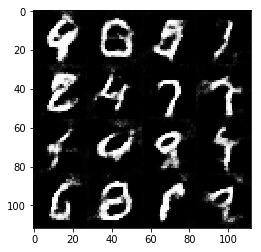

Epoch 1/2... Discriminator Loss: 0.9886... Generator Loss: 1.2031
Epoch 1/2... Discriminator Loss: 1.0668... Generator Loss: 0.6612
Epoch 1/2... Discriminator Loss: 0.9796... Generator Loss: 1.4909
Epoch 1/2... Discriminator Loss: 1.2736... Generator Loss: 2.1721
Epoch 1/2... Discriminator Loss: 0.9111... Generator Loss: 1.3470
Epoch 1/2... Discriminator Loss: 1.1730... Generator Loss: 0.5368
Epoch 2/2... Discriminator Loss: 0.8850... Generator Loss: 1.4326
Epoch 2/2... Discriminator Loss: 0.9135... Generator Loss: 1.3313
Epoch 2/2... Discriminator Loss: 1.0851... Generator Loss: 1.9071
Epoch 2/2... Discriminator Loss: 0.9486... Generator Loss: 0.7982


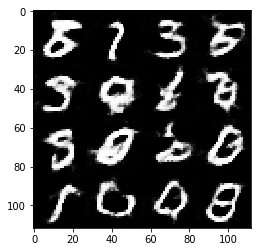

Epoch 2/2... Discriminator Loss: 0.9171... Generator Loss: 1.0614
Epoch 2/2... Discriminator Loss: 0.9380... Generator Loss: 0.9080
Epoch 2/2... Discriminator Loss: 0.8880... Generator Loss: 1.3258
Epoch 2/2... Discriminator Loss: 0.9526... Generator Loss: 0.7748
Epoch 2/2... Discriminator Loss: 0.9465... Generator Loss: 0.8529
Epoch 2/2... Discriminator Loss: 0.9708... Generator Loss: 1.8354
Epoch 2/2... Discriminator Loss: 0.8448... Generator Loss: 1.6569
Epoch 2/2... Discriminator Loss: 1.0536... Generator Loss: 2.1813
Epoch 2/2... Discriminator Loss: 0.9479... Generator Loss: 0.9018
Epoch 2/2... Discriminator Loss: 0.9116... Generator Loss: 0.9543


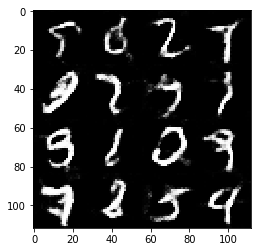

Epoch 2/2... Discriminator Loss: 0.9384... Generator Loss: 1.7373
Epoch 2/2... Discriminator Loss: 0.9497... Generator Loss: 1.1153
Epoch 2/2... Discriminator Loss: 1.1447... Generator Loss: 0.5694
Epoch 2/2... Discriminator Loss: 0.8745... Generator Loss: 1.3775
Epoch 2/2... Discriminator Loss: 0.8646... Generator Loss: 1.5119
Epoch 2/2... Discriminator Loss: 0.8668... Generator Loss: 1.1757
Epoch 2/2... Discriminator Loss: 0.9756... Generator Loss: 0.8026
Epoch 2/2... Discriminator Loss: 0.8945... Generator Loss: 1.0164
Epoch 2/2... Discriminator Loss: 0.8268... Generator Loss: 1.3385
Epoch 2/2... Discriminator Loss: 0.8472... Generator Loss: 1.9259


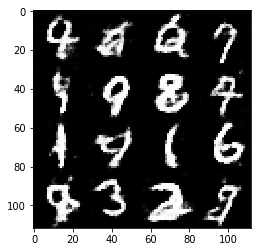

Epoch 2/2... Discriminator Loss: 0.9188... Generator Loss: 1.5475
Epoch 2/2... Discriminator Loss: 0.9559... Generator Loss: 1.6452
Epoch 2/2... Discriminator Loss: 0.8274... Generator Loss: 1.2892
Epoch 2/2... Discriminator Loss: 1.0275... Generator Loss: 2.2787
Epoch 2/2... Discriminator Loss: 0.9326... Generator Loss: 0.8088
Epoch 2/2... Discriminator Loss: 0.8508... Generator Loss: 1.6899
Epoch 2/2... Discriminator Loss: 0.8251... Generator Loss: 1.5558
Epoch 2/2... Discriminator Loss: 0.9086... Generator Loss: 1.8432
Epoch 2/2... Discriminator Loss: 0.8118... Generator Loss: 1.6587
Epoch 2/2... Discriminator Loss: 0.6905... Generator Loss: 1.2279


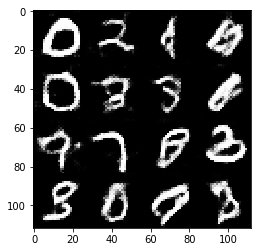

Epoch 2/2... Discriminator Loss: 0.8417... Generator Loss: 1.1170
Epoch 2/2... Discriminator Loss: 0.9259... Generator Loss: 0.7748
Epoch 2/2... Discriminator Loss: 0.8542... Generator Loss: 0.9797
Epoch 2/2... Discriminator Loss: 0.8399... Generator Loss: 1.9985
Epoch 2/2... Discriminator Loss: 0.8590... Generator Loss: 0.8767
Epoch 2/2... Discriminator Loss: 0.8953... Generator Loss: 0.7508
Epoch 2/2... Discriminator Loss: 1.0055... Generator Loss: 1.9085
Epoch 2/2... Discriminator Loss: 0.8891... Generator Loss: 1.9134
Epoch 2/2... Discriminator Loss: 0.8155... Generator Loss: 1.4670
Epoch 2/2... Discriminator Loss: 0.8361... Generator Loss: 1.0776


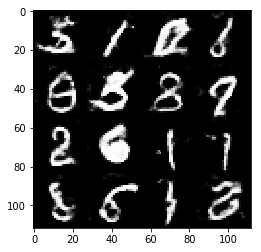

Epoch 2/2... Discriminator Loss: 0.8450... Generator Loss: 1.6156
Epoch 2/2... Discriminator Loss: 1.0121... Generator Loss: 0.6610
Epoch 2/2... Discriminator Loss: 0.8843... Generator Loss: 1.7622


In [86]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

initial output:


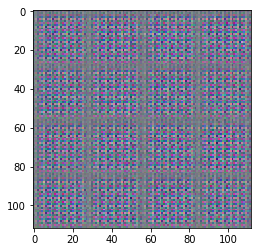

Epoch 1/1... Discriminator Loss: 0.0107... Generator Loss: 9.3419
Epoch 1/1... Discriminator Loss: 0.0023... Generator Loss: 7.5477
Epoch 1/1... Discriminator Loss: 0.0094... Generator Loss: 9.0556
Epoch 1/1... Discriminator Loss: 10.9855... Generator Loss: 23.3197
Epoch 1/1... Discriminator Loss: 0.0646... Generator Loss: 3.8681
Epoch 1/1... Discriminator Loss: 0.4190... Generator Loss: 8.0546
Epoch 1/1... Discriminator Loss: 2.5751... Generator Loss: 10.0989
Epoch 1/1... Discriminator Loss: 0.3368... Generator Loss: 6.4035
Epoch 1/1... Discriminator Loss: 0.1498... Generator Loss: 6.0864
Epoch 1/1... Discriminator Loss: 0.3863... Generator Loss: 7.2453


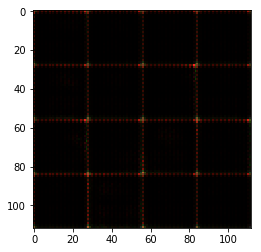

Epoch 1/1... Discriminator Loss: 0.0323... Generator Loss: 5.0844
Epoch 1/1... Discriminator Loss: 0.0667... Generator Loss: 4.4809
Epoch 1/1... Discriminator Loss: 0.4544... Generator Loss: 10.5515
Epoch 1/1... Discriminator Loss: 0.6331... Generator Loss: 1.1161
Epoch 1/1... Discriminator Loss: 0.5808... Generator Loss: 2.0905
Epoch 1/1... Discriminator Loss: 0.3282... Generator Loss: 1.7567
Epoch 1/1... Discriminator Loss: 0.2950... Generator Loss: 2.3422
Epoch 1/1... Discriminator Loss: 0.7635... Generator Loss: 2.0351
Epoch 1/1... Discriminator Loss: 0.5334... Generator Loss: 1.8931
Epoch 1/1... Discriminator Loss: 0.8556... Generator Loss: 2.9780


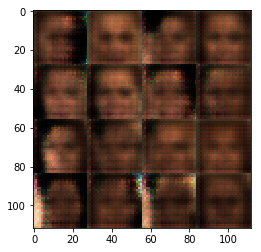

Epoch 1/1... Discriminator Loss: 0.3046... Generator Loss: 2.7034
Epoch 1/1... Discriminator Loss: 0.5465... Generator Loss: 1.4947
Epoch 1/1... Discriminator Loss: 0.4806... Generator Loss: 1.9973
Epoch 1/1... Discriminator Loss: 0.5461... Generator Loss: 1.1556
Epoch 1/1... Discriminator Loss: 0.4052... Generator Loss: 2.5854
Epoch 1/1... Discriminator Loss: 0.4222... Generator Loss: 2.1658
Epoch 1/1... Discriminator Loss: 0.4386... Generator Loss: 2.0895
Epoch 1/1... Discriminator Loss: 1.3386... Generator Loss: 3.0719
Epoch 1/1... Discriminator Loss: 0.7531... Generator Loss: 1.3189
Epoch 1/1... Discriminator Loss: 0.9064... Generator Loss: 3.0234


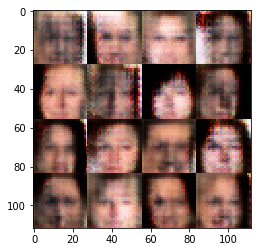

Epoch 1/1... Discriminator Loss: 0.4324... Generator Loss: 2.2496
Epoch 1/1... Discriminator Loss: 0.6105... Generator Loss: 2.1229
Epoch 1/1... Discriminator Loss: 0.9643... Generator Loss: 0.6559
Epoch 1/1... Discriminator Loss: 0.8444... Generator Loss: 2.5572
Epoch 1/1... Discriminator Loss: 0.8204... Generator Loss: 1.6082
Epoch 1/1... Discriminator Loss: 0.8656... Generator Loss: 1.9171
Epoch 1/1... Discriminator Loss: 0.5416... Generator Loss: 1.4102
Epoch 1/1... Discriminator Loss: 0.4318... Generator Loss: 1.7134
Epoch 1/1... Discriminator Loss: 0.6799... Generator Loss: 1.2429
Epoch 1/1... Discriminator Loss: 0.4602... Generator Loss: 1.6679


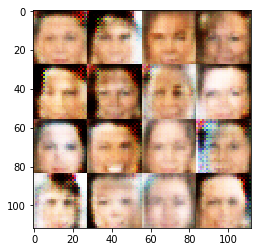

Epoch 1/1... Discriminator Loss: 1.1387... Generator Loss: 2.3018
Epoch 1/1... Discriminator Loss: 0.4242... Generator Loss: 2.1077
Epoch 1/1... Discriminator Loss: 0.7399... Generator Loss: 3.4222
Epoch 1/1... Discriminator Loss: 1.8139... Generator Loss: 3.1029
Epoch 1/1... Discriminator Loss: 0.5351... Generator Loss: 1.6380
Epoch 1/1... Discriminator Loss: 0.9133... Generator Loss: 1.1200
Epoch 1/1... Discriminator Loss: 0.8600... Generator Loss: 1.6846
Epoch 1/1... Discriminator Loss: 0.6296... Generator Loss: 1.8128
Epoch 1/1... Discriminator Loss: 1.4782... Generator Loss: 2.2161
Epoch 1/1... Discriminator Loss: 1.1017... Generator Loss: 1.6942


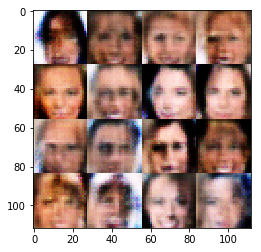

Epoch 1/1... Discriminator Loss: 1.0870... Generator Loss: 0.6149
Epoch 1/1... Discriminator Loss: 1.0913... Generator Loss: 0.8614
Epoch 1/1... Discriminator Loss: 0.7671... Generator Loss: 0.9496
Epoch 1/1... Discriminator Loss: 1.0668... Generator Loss: 2.1393
Epoch 1/1... Discriminator Loss: 0.5298... Generator Loss: 1.3005
Epoch 1/1... Discriminator Loss: 0.6432... Generator Loss: 1.0760
Epoch 1/1... Discriminator Loss: 0.6338... Generator Loss: 1.3844
Epoch 1/1... Discriminator Loss: 1.1210... Generator Loss: 0.6689
Epoch 1/1... Discriminator Loss: 0.9738... Generator Loss: 0.7118
Epoch 1/1... Discriminator Loss: 1.0067... Generator Loss: 1.0699


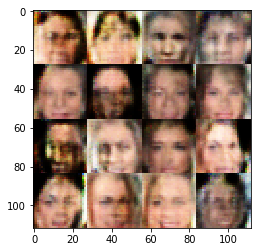

Epoch 1/1... Discriminator Loss: 0.8280... Generator Loss: 1.5182
Epoch 1/1... Discriminator Loss: 0.8069... Generator Loss: 2.1120
Epoch 1/1... Discriminator Loss: 0.5962... Generator Loss: 2.8788
Epoch 1/1... Discriminator Loss: 0.8409... Generator Loss: 1.3739
Epoch 1/1... Discriminator Loss: 0.6013... Generator Loss: 1.5510
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.4059
Epoch 1/1... Discriminator Loss: 0.6541... Generator Loss: 1.2828
Epoch 1/1... Discriminator Loss: 0.9490... Generator Loss: 1.4003
Epoch 1/1... Discriminator Loss: 0.7157... Generator Loss: 0.8834
Epoch 1/1... Discriminator Loss: 0.9544... Generator Loss: 1.5365


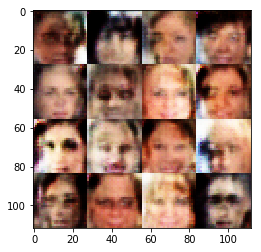

Epoch 1/1... Discriminator Loss: 0.9794... Generator Loss: 1.1955
Epoch 1/1... Discriminator Loss: 0.8673... Generator Loss: 1.5994
Epoch 1/1... Discriminator Loss: 0.5226... Generator Loss: 1.9444
Epoch 1/1... Discriminator Loss: 0.6748... Generator Loss: 1.3436
Epoch 1/1... Discriminator Loss: 1.2765... Generator Loss: 1.5528
Epoch 1/1... Discriminator Loss: 0.9222... Generator Loss: 1.0446
Epoch 1/1... Discriminator Loss: 0.9743... Generator Loss: 1.6908
Epoch 1/1... Discriminator Loss: 0.6254... Generator Loss: 1.4175
Epoch 1/1... Discriminator Loss: 1.4254... Generator Loss: 3.2393
Epoch 1/1... Discriminator Loss: 0.5526... Generator Loss: 1.8788


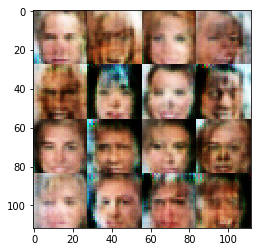

Epoch 1/1... Discriminator Loss: 0.7358... Generator Loss: 1.5439
Epoch 1/1... Discriminator Loss: 0.7162... Generator Loss: 1.0316
Epoch 1/1... Discriminator Loss: 0.7822... Generator Loss: 1.4278
Epoch 1/1... Discriminator Loss: 1.1254... Generator Loss: 2.7593
Epoch 1/1... Discriminator Loss: 0.8901... Generator Loss: 0.7780
Epoch 1/1... Discriminator Loss: 0.8940... Generator Loss: 1.7708
Epoch 1/1... Discriminator Loss: 1.2661... Generator Loss: 2.4571
Epoch 1/1... Discriminator Loss: 0.9577... Generator Loss: 1.3385
Epoch 1/1... Discriminator Loss: 0.9449... Generator Loss: 0.7839
Epoch 1/1... Discriminator Loss: 1.0604... Generator Loss: 1.0299


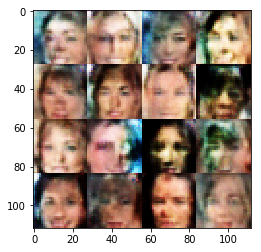

Epoch 1/1... Discriminator Loss: 0.7878... Generator Loss: 1.4543
Epoch 1/1... Discriminator Loss: 0.9465... Generator Loss: 2.1308
Epoch 1/1... Discriminator Loss: 0.9438... Generator Loss: 1.0391
Epoch 1/1... Discriminator Loss: 0.8934... Generator Loss: 1.9438
Epoch 1/1... Discriminator Loss: 1.0261... Generator Loss: 0.7585
Epoch 1/1... Discriminator Loss: 0.9278... Generator Loss: 1.8579
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 2.0351
Epoch 1/1... Discriminator Loss: 0.9018... Generator Loss: 1.4539
Epoch 1/1... Discriminator Loss: 1.0676... Generator Loss: 0.8639
Epoch 1/1... Discriminator Loss: 0.8909... Generator Loss: 1.8827


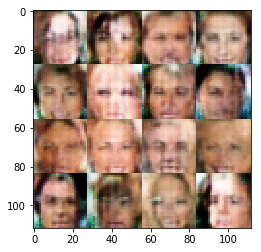

Epoch 1/1... Discriminator Loss: 1.0841... Generator Loss: 0.8129
Epoch 1/1... Discriminator Loss: 1.1226... Generator Loss: 1.0247
Epoch 1/1... Discriminator Loss: 0.9047... Generator Loss: 1.8143
Epoch 1/1... Discriminator Loss: 0.9577... Generator Loss: 1.8585
Epoch 1/1... Discriminator Loss: 0.8721... Generator Loss: 1.6955
Epoch 1/1... Discriminator Loss: 0.6197... Generator Loss: 1.5565
Epoch 1/1... Discriminator Loss: 0.9818... Generator Loss: 1.0195
Epoch 1/1... Discriminator Loss: 0.9110... Generator Loss: 1.1959
Epoch 1/1... Discriminator Loss: 1.5181... Generator Loss: 2.2740
Epoch 1/1... Discriminator Loss: 0.7476... Generator Loss: 1.9295


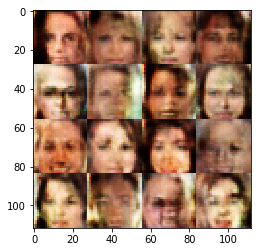

Epoch 1/1... Discriminator Loss: 1.0765... Generator Loss: 1.5294
Epoch 1/1... Discriminator Loss: 1.2822... Generator Loss: 0.4289
Epoch 1/1... Discriminator Loss: 0.9414... Generator Loss: 0.8882
Epoch 1/1... Discriminator Loss: 0.9750... Generator Loss: 0.7357
Epoch 1/1... Discriminator Loss: 0.4535... Generator Loss: 1.6472
Epoch 1/1... Discriminator Loss: 0.9934... Generator Loss: 0.9112
Epoch 1/1... Discriminator Loss: 0.9982... Generator Loss: 1.1995
Epoch 1/1... Discriminator Loss: 1.0079... Generator Loss: 1.5529
Epoch 1/1... Discriminator Loss: 1.0246... Generator Loss: 0.9834
Epoch 1/1... Discriminator Loss: 0.6211... Generator Loss: 1.5124


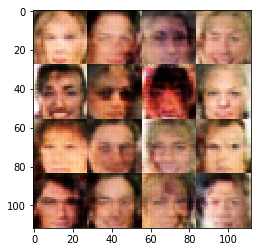

Epoch 1/1... Discriminator Loss: 0.8243... Generator Loss: 0.9320
Epoch 1/1... Discriminator Loss: 1.0225... Generator Loss: 0.7583
Epoch 1/1... Discriminator Loss: 1.0822... Generator Loss: 0.9329
Epoch 1/1... Discriminator Loss: 1.0334... Generator Loss: 1.8684
Epoch 1/1... Discriminator Loss: 1.0016... Generator Loss: 1.0873
Epoch 1/1... Discriminator Loss: 1.1633... Generator Loss: 0.9405
Epoch 1/1... Discriminator Loss: 1.1405... Generator Loss: 1.1476
Epoch 1/1... Discriminator Loss: 1.2417... Generator Loss: 1.5346
Epoch 1/1... Discriminator Loss: 1.0740... Generator Loss: 0.7491
Epoch 1/1... Discriminator Loss: 0.9257... Generator Loss: 0.8082


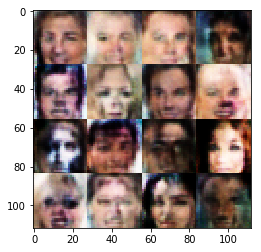

Epoch 1/1... Discriminator Loss: 0.9390... Generator Loss: 1.5485
Epoch 1/1... Discriminator Loss: 1.1014... Generator Loss: 1.2746
Epoch 1/1... Discriminator Loss: 1.2261... Generator Loss: 0.5438
Epoch 1/1... Discriminator Loss: 0.9549... Generator Loss: 1.4374
Epoch 1/1... Discriminator Loss: 0.8075... Generator Loss: 1.0810
Epoch 1/1... Discriminator Loss: 1.0467... Generator Loss: 0.6778
Epoch 1/1... Discriminator Loss: 1.2519... Generator Loss: 1.7194
Epoch 1/1... Discriminator Loss: 0.7728... Generator Loss: 1.2445
Epoch 1/1... Discriminator Loss: 0.7494... Generator Loss: 1.1657
Epoch 1/1... Discriminator Loss: 0.8569... Generator Loss: 1.8712


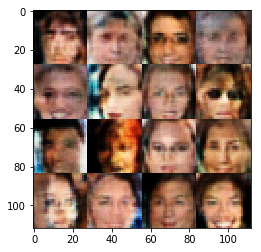

Epoch 1/1... Discriminator Loss: 1.1409... Generator Loss: 1.0708
Epoch 1/1... Discriminator Loss: 0.9629... Generator Loss: 0.9816
Epoch 1/1... Discriminator Loss: 1.3252... Generator Loss: 2.2360
Epoch 1/1... Discriminator Loss: 1.0733... Generator Loss: 1.4429
Epoch 1/1... Discriminator Loss: 0.8308... Generator Loss: 1.6009
Epoch 1/1... Discriminator Loss: 0.9844... Generator Loss: 0.9846
Epoch 1/1... Discriminator Loss: 1.0634... Generator Loss: 0.9614
Epoch 1/1... Discriminator Loss: 0.9384... Generator Loss: 1.1803
Epoch 1/1... Discriminator Loss: 0.7730... Generator Loss: 1.6907
Epoch 1/1... Discriminator Loss: 0.9795... Generator Loss: 1.5503


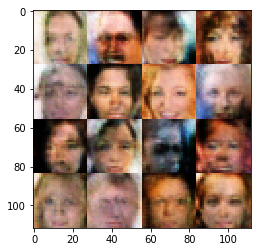

Epoch 1/1... Discriminator Loss: 1.0206... Generator Loss: 1.2618
Epoch 1/1... Discriminator Loss: 1.0122... Generator Loss: 1.1342
Epoch 1/1... Discriminator Loss: 1.2027... Generator Loss: 0.9910
Epoch 1/1... Discriminator Loss: 0.8724... Generator Loss: 1.1005
Epoch 1/1... Discriminator Loss: 0.9845... Generator Loss: 1.0177
Epoch 1/1... Discriminator Loss: 1.0780... Generator Loss: 0.7623
Epoch 1/1... Discriminator Loss: 0.9550... Generator Loss: 1.1887
Epoch 1/1... Discriminator Loss: 1.2101... Generator Loss: 1.0584
Epoch 1/1... Discriminator Loss: 1.0199... Generator Loss: 0.9265
Epoch 1/1... Discriminator Loss: 1.0353... Generator Loss: 1.0800


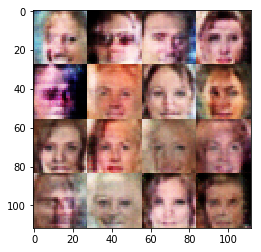

Epoch 1/1... Discriminator Loss: 1.0527... Generator Loss: 1.1488
Epoch 1/1... Discriminator Loss: 0.9228... Generator Loss: 1.0359
Epoch 1/1... Discriminator Loss: 1.0204... Generator Loss: 0.9781
Epoch 1/1... Discriminator Loss: 1.0514... Generator Loss: 0.9455
Epoch 1/1... Discriminator Loss: 0.9098... Generator Loss: 0.7840
Epoch 1/1... Discriminator Loss: 1.0552... Generator Loss: 0.7976
Epoch 1/1... Discriminator Loss: 0.9644... Generator Loss: 1.2537
Epoch 1/1... Discriminator Loss: 1.0888... Generator Loss: 0.9074
Epoch 1/1... Discriminator Loss: 1.0054... Generator Loss: 1.3283
Epoch 1/1... Discriminator Loss: 1.0683... Generator Loss: 0.9690


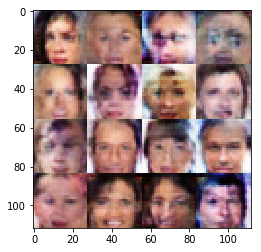

Epoch 1/1... Discriminator Loss: 1.2184... Generator Loss: 1.2433
Epoch 1/1... Discriminator Loss: 1.0805... Generator Loss: 0.8973
Epoch 1/1... Discriminator Loss: 1.1110... Generator Loss: 1.2216
Epoch 1/1... Discriminator Loss: 1.1567... Generator Loss: 0.9785
Epoch 1/1... Discriminator Loss: 1.0164... Generator Loss: 1.1007
Epoch 1/1... Discriminator Loss: 1.0388... Generator Loss: 1.4389
Epoch 1/1... Discriminator Loss: 0.9700... Generator Loss: 1.1522
Epoch 1/1... Discriminator Loss: 1.1228... Generator Loss: 0.8907
Epoch 1/1... Discriminator Loss: 1.0046... Generator Loss: 0.9907
Epoch 1/1... Discriminator Loss: 1.0333... Generator Loss: 0.8309


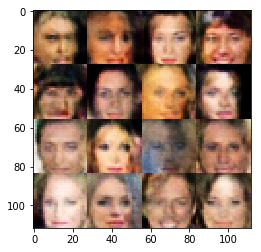

Epoch 1/1... Discriminator Loss: 0.8264... Generator Loss: 1.1758
Epoch 1/1... Discriminator Loss: 1.0984... Generator Loss: 1.1268
Epoch 1/1... Discriminator Loss: 1.0803... Generator Loss: 1.0587
Epoch 1/1... Discriminator Loss: 1.2320... Generator Loss: 0.5152
Epoch 1/1... Discriminator Loss: 1.0661... Generator Loss: 1.0164
Epoch 1/1... Discriminator Loss: 0.7780... Generator Loss: 1.2825
Epoch 1/1... Discriminator Loss: 0.9272... Generator Loss: 1.1921
Epoch 1/1... Discriminator Loss: 1.0439... Generator Loss: 2.0503
Epoch 1/1... Discriminator Loss: 1.2274... Generator Loss: 1.0135
Epoch 1/1... Discriminator Loss: 1.0049... Generator Loss: 1.5216


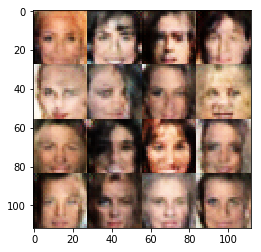

Epoch 1/1... Discriminator Loss: 0.9530... Generator Loss: 0.9790
Epoch 1/1... Discriminator Loss: 1.1396... Generator Loss: 1.5068
Epoch 1/1... Discriminator Loss: 0.9333... Generator Loss: 1.4864
Epoch 1/1... Discriminator Loss: 1.1678... Generator Loss: 1.3437
Epoch 1/1... Discriminator Loss: 1.1191... Generator Loss: 1.0205
Epoch 1/1... Discriminator Loss: 0.9029... Generator Loss: 1.0141
Epoch 1/1... Discriminator Loss: 0.9146... Generator Loss: 1.3491
Epoch 1/1... Discriminator Loss: 0.9414... Generator Loss: 0.9659
Epoch 1/1... Discriminator Loss: 1.1360... Generator Loss: 0.7590
Epoch 1/1... Discriminator Loss: 1.1638... Generator Loss: 0.6421


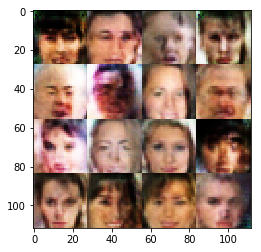

Epoch 1/1... Discriminator Loss: 0.9512... Generator Loss: 0.9639
Epoch 1/1... Discriminator Loss: 1.1102... Generator Loss: 1.1202
Epoch 1/1... Discriminator Loss: 1.1248... Generator Loss: 1.4227
Epoch 1/1... Discriminator Loss: 0.6801... Generator Loss: 1.5716
Epoch 1/1... Discriminator Loss: 0.9872... Generator Loss: 1.1235
Epoch 1/1... Discriminator Loss: 0.9283... Generator Loss: 1.2972
Epoch 1/1... Discriminator Loss: 0.7374... Generator Loss: 1.6378
Epoch 1/1... Discriminator Loss: 1.0341... Generator Loss: 0.6954
Epoch 1/1... Discriminator Loss: 0.8585... Generator Loss: 1.4844
Epoch 1/1... Discriminator Loss: 1.2016... Generator Loss: 0.8805


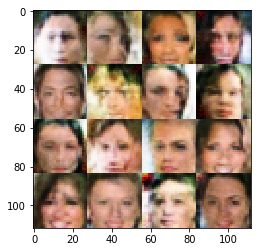

Epoch 1/1... Discriminator Loss: 0.9723... Generator Loss: 1.2195
Epoch 1/1... Discriminator Loss: 1.0883... Generator Loss: 1.4632
Epoch 1/1... Discriminator Loss: 0.7706... Generator Loss: 1.5738
Epoch 1/1... Discriminator Loss: 0.9395... Generator Loss: 1.0736
Epoch 1/1... Discriminator Loss: 0.9535... Generator Loss: 1.7463
Epoch 1/1... Discriminator Loss: 0.9488... Generator Loss: 1.6096
Epoch 1/1... Discriminator Loss: 0.9448... Generator Loss: 1.3300
Epoch 1/1... Discriminator Loss: 1.2362... Generator Loss: 0.5939
Epoch 1/1... Discriminator Loss: 0.9594... Generator Loss: 1.0069
Epoch 1/1... Discriminator Loss: 1.1897... Generator Loss: 1.5326


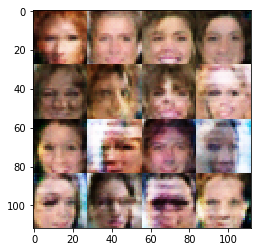

Epoch 1/1... Discriminator Loss: 1.0677... Generator Loss: 0.9720
Epoch 1/1... Discriminator Loss: 0.8987... Generator Loss: 1.1087
Epoch 1/1... Discriminator Loss: 1.0887... Generator Loss: 1.0024
Epoch 1/1... Discriminator Loss: 1.0229... Generator Loss: 1.2822
Epoch 1/1... Discriminator Loss: 1.0470... Generator Loss: 1.3112
Epoch 1/1... Discriminator Loss: 0.9894... Generator Loss: 1.0098
Epoch 1/1... Discriminator Loss: 1.1576... Generator Loss: 0.7949
Epoch 1/1... Discriminator Loss: 1.0933... Generator Loss: 1.0697
Epoch 1/1... Discriminator Loss: 1.1882... Generator Loss: 1.4292
Epoch 1/1... Discriminator Loss: 1.0561... Generator Loss: 0.9526


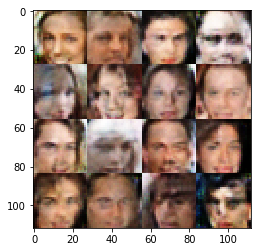

Epoch 1/1... Discriminator Loss: 0.8652... Generator Loss: 1.1283
Epoch 1/1... Discriminator Loss: 1.0984... Generator Loss: 0.8258
Epoch 1/1... Discriminator Loss: 1.0093... Generator Loss: 0.8795
Epoch 1/1... Discriminator Loss: 1.1063... Generator Loss: 0.8851
Epoch 1/1... Discriminator Loss: 1.0905... Generator Loss: 1.0919
Epoch 1/1... Discriminator Loss: 0.9522... Generator Loss: 1.1691
Epoch 1/1... Discriminator Loss: 1.0595... Generator Loss: 0.7302
Epoch 1/1... Discriminator Loss: 1.1269... Generator Loss: 0.8618
Epoch 1/1... Discriminator Loss: 0.9853... Generator Loss: 1.0522
Epoch 1/1... Discriminator Loss: 1.1457... Generator Loss: 0.8779


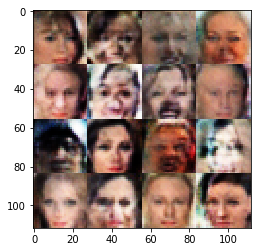

Epoch 1/1... Discriminator Loss: 0.9527... Generator Loss: 1.0149
Epoch 1/1... Discriminator Loss: 1.1358... Generator Loss: 0.6843
Epoch 1/1... Discriminator Loss: 1.1182... Generator Loss: 1.0932
Epoch 1/1... Discriminator Loss: 1.0155... Generator Loss: 1.0418
Epoch 1/1... Discriminator Loss: 1.0326... Generator Loss: 1.0003
Epoch 1/1... Discriminator Loss: 1.0075... Generator Loss: 1.0163
Epoch 1/1... Discriminator Loss: 1.1043... Generator Loss: 0.8442
Epoch 1/1... Discriminator Loss: 0.9800... Generator Loss: 0.9447
Epoch 1/1... Discriminator Loss: 0.9889... Generator Loss: 0.9200
Epoch 1/1... Discriminator Loss: 1.0689... Generator Loss: 1.1503


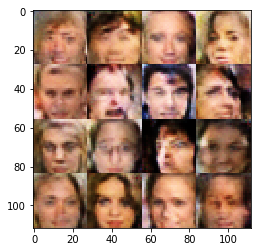

Epoch 1/1... Discriminator Loss: 0.8678... Generator Loss: 1.3362
Epoch 1/1... Discriminator Loss: 1.0815... Generator Loss: 1.3540
Epoch 1/1... Discriminator Loss: 1.1535... Generator Loss: 0.8636
Epoch 1/1... Discriminator Loss: 1.1629... Generator Loss: 1.1808
Epoch 1/1... Discriminator Loss: 1.1393... Generator Loss: 1.5338
Epoch 1/1... Discriminator Loss: 1.0415... Generator Loss: 0.8524
Epoch 1/1... Discriminator Loss: 1.0591... Generator Loss: 1.1091
Epoch 1/1... Discriminator Loss: 1.0129... Generator Loss: 0.9973
Epoch 1/1... Discriminator Loss: 1.0232... Generator Loss: 0.9596
Epoch 1/1... Discriminator Loss: 1.1186... Generator Loss: 1.4328


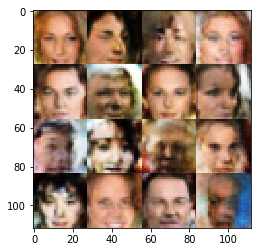

Epoch 1/1... Discriminator Loss: 1.1195... Generator Loss: 0.8809
Epoch 1/1... Discriminator Loss: 1.1599... Generator Loss: 0.8357
Epoch 1/1... Discriminator Loss: 1.1631... Generator Loss: 1.3951
Epoch 1/1... Discriminator Loss: 1.1186... Generator Loss: 0.8991
Epoch 1/1... Discriminator Loss: 1.1249... Generator Loss: 0.9549
Epoch 1/1... Discriminator Loss: 1.1791... Generator Loss: 0.9818
Epoch 1/1... Discriminator Loss: 1.0855... Generator Loss: 0.9075
Epoch 1/1... Discriminator Loss: 1.0828... Generator Loss: 0.8922
Epoch 1/1... Discriminator Loss: 1.0235... Generator Loss: 1.3539
Epoch 1/1... Discriminator Loss: 1.1590... Generator Loss: 0.8221


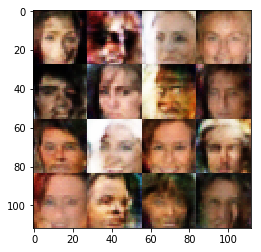

Epoch 1/1... Discriminator Loss: 1.0697... Generator Loss: 0.9831
Epoch 1/1... Discriminator Loss: 1.1314... Generator Loss: 0.9795
Epoch 1/1... Discriminator Loss: 1.0202... Generator Loss: 0.9449
Epoch 1/1... Discriminator Loss: 1.0932... Generator Loss: 1.0157
Epoch 1/1... Discriminator Loss: 1.0745... Generator Loss: 1.0926
Epoch 1/1... Discriminator Loss: 1.1090... Generator Loss: 0.7132
Epoch 1/1... Discriminator Loss: 1.1202... Generator Loss: 0.8367
Epoch 1/1... Discriminator Loss: 1.2008... Generator Loss: 1.0123
Epoch 1/1... Discriminator Loss: 1.0633... Generator Loss: 0.9410
Epoch 1/1... Discriminator Loss: 1.1566... Generator Loss: 0.9126


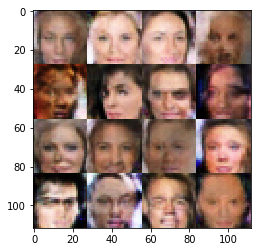

Epoch 1/1... Discriminator Loss: 1.1250... Generator Loss: 0.8241
Epoch 1/1... Discriminator Loss: 1.1263... Generator Loss: 0.8166
Epoch 1/1... Discriminator Loss: 1.2035... Generator Loss: 0.9622
Epoch 1/1... Discriminator Loss: 1.1060... Generator Loss: 0.9719
Epoch 1/1... Discriminator Loss: 1.0629... Generator Loss: 0.9789
Epoch 1/1... Discriminator Loss: 1.1753... Generator Loss: 0.8888
Epoch 1/1... Discriminator Loss: 1.1460... Generator Loss: 0.8272
Epoch 1/1... Discriminator Loss: 0.9284... Generator Loss: 1.1662
Epoch 1/1... Discriminator Loss: 1.1090... Generator Loss: 0.9181
Epoch 1/1... Discriminator Loss: 1.1478... Generator Loss: 0.9252


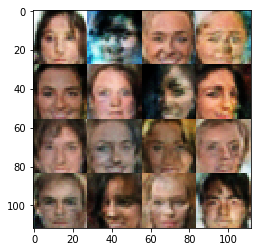

Epoch 1/1... Discriminator Loss: 1.2069... Generator Loss: 0.7800
Epoch 1/1... Discriminator Loss: 1.2159... Generator Loss: 1.0044
Epoch 1/1... Discriminator Loss: 1.1304... Generator Loss: 1.0022
Epoch 1/1... Discriminator Loss: 1.1369... Generator Loss: 1.1167
Epoch 1/1... Discriminator Loss: 1.1317... Generator Loss: 0.9721
Epoch 1/1... Discriminator Loss: 1.0639... Generator Loss: 0.9978
Epoch 1/1... Discriminator Loss: 1.0935... Generator Loss: 0.8759
Epoch 1/1... Discriminator Loss: 1.1502... Generator Loss: 0.9597
Epoch 1/1... Discriminator Loss: 1.1852... Generator Loss: 0.8532
Epoch 1/1... Discriminator Loss: 1.1620... Generator Loss: 0.9201


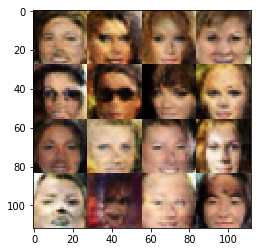

Epoch 1/1... Discriminator Loss: 0.9590... Generator Loss: 0.8725
Epoch 1/1... Discriminator Loss: 1.0634... Generator Loss: 0.9218
Epoch 1/1... Discriminator Loss: 1.0110... Generator Loss: 1.2122
Epoch 1/1... Discriminator Loss: 1.0610... Generator Loss: 1.1899
Epoch 1/1... Discriminator Loss: 1.1503... Generator Loss: 0.8759
Epoch 1/1... Discriminator Loss: 1.1227... Generator Loss: 0.8006
Epoch 1/1... Discriminator Loss: 1.1239... Generator Loss: 0.9143
Epoch 1/1... Discriminator Loss: 1.0595... Generator Loss: 1.1286
Epoch 1/1... Discriminator Loss: 1.2310... Generator Loss: 0.7658
Epoch 1/1... Discriminator Loss: 1.2006... Generator Loss: 1.0316


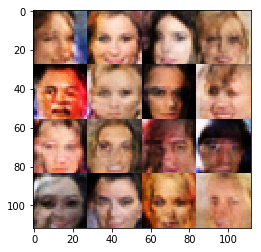

Epoch 1/1... Discriminator Loss: 1.0515... Generator Loss: 1.1350
Epoch 1/1... Discriminator Loss: 1.0917... Generator Loss: 1.0256
Epoch 1/1... Discriminator Loss: 1.2899... Generator Loss: 0.9223
Epoch 1/1... Discriminator Loss: 1.1600... Generator Loss: 0.8465
Epoch 1/1... Discriminator Loss: 1.2619... Generator Loss: 0.7952
Epoch 1/1... Discriminator Loss: 0.8819... Generator Loss: 1.0967


In [87]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.